# Introduction

This project analyzes nighttime aircraft noise complaints around San Francisco International Airport (SFO) to understand which neighborhoods are most affected and what factors contribute to the disturbance.

Our analysis focuses on three objectives:

- Identifying the neighborhoods with the highest number of nighttime reports (8 PM–7 AM).

- Examining how aircraft type, altitude, operation type, hour of night, and season influence noise-related reporting patterns.

- Building a simple predictive model to estimate complaint levels from flight characteristics and to evaluate how changes in operations might reduce nighttime noise.

By cleaning, analyzing, and modeling SFO’s nighttime noise-complaint data, this project aims to provide insights that can help both residents and airport authorities address ongoing noise challenges more effectively.

# Data Source

We use the publicly available SFO Aircraft Noise Reports dataset from Data.gov : https://catalog.data.gov/dataset/sfo-aircraft-noise-reports. 
This dataset records every noise complaint submitted by residents living near SFO from 2018 to the present.
For our project, we focus specifically on night-time complaints (8 PM–7 AM) and extract variables such as:

- Disturbance date and time

- Reporter’s city and postal code

- Aircraft altitude

- Aircraft type

- Operation type (Arrival/Departure)

- Airport ID

- Hour of disturbance

Before analysis or modeling, the dataset requires substantial cleaning to remove irrelevant entries, fix date formats, handle missing values, and reduce the file size.

# Data Preparation
## 1. Load libraries and dataset

We first import Python libraries that we will use throughout the project:

pandas → data manipulation

numpy → numerical operations

matplotlib and seaborn → visualizations

We then load the dataset into a DataFrame to begin exploration.

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_style("whitegrid")

In [ ]:
df = pd.read_csv("../data/Aircraft_Noise_Reports.csv")
df.head()


/var/folders/sc/pdyvxd7s6yg_4vmwpgn89ld80000gn/T/ipykernel_18572/1413754666.py:2: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/Aircraft_Noise_Reports.csv")


,disturbance_date_time,report_method,corr_id,reporter_city,reporter_postal_code,aircraft_pca_altitude,airport_id,operation_type,runway_name,flight_no,aircraft_type,destination_origin,data_as_of,data_loaded_at
0,2024/08/18 07:21:21 PM,Email,20662792,Palo Alto,94301,4911.0,SFO,A,28L,AAL2165,A319,LAX,2024/09/26 11:38:51 AM,2025/10/07 06:22:50 AM
1,2024/08/18 07:21:42 PM,AWA App,20662333,Portola Valley,94028,4610.0,SFO,A,28L,ASA129,B739,LAS,2024/09/26 11:38:51 AM,2025/10/07 06:22:50 AM
2,2024/08/18 07:21:46 PM,AWA App,20662792,Palo Alto,94303,4803.0,SFO,A,28L,AAL2165,A319,LAX,2024/09/26 11:38:51 AM,2025/10/07 06:22:50 AM
3,2024/08/18 07:24:40 PM,AWA App,20663178,Redwood City,94061,4390.0,SFO,A,28R,UAL1947,B39M,HNL,2024/09/26 11:38:51 AM,2025/10/07 06:22:50 AM
4,2024/09/13 07:09:59 PM,AWA App,20692087,Santa Cruz,95065,11378.0,SFO,A,28L,UAL2320,B739,LAX,2024/11/07 05:04:54 PM,2025/10/07 06:22:50 AM


This allows us to inspect the dataset and see the first few records. It gives an overview of which columns are available and the general structure of the data.

## 2. Remove Unecessary columns

The raw dataset contains many fields we do not need for our analysis.
By keeping only the columns relevant to our project, we reduce memory usage and simplify the dataset.

In [ ]:

columns_to_load = [
    'disturbance_date_time', 'reporter_city', 'reporter_postal_code',
    'aircraft_pca_altitude', 'airport_id', 'operation_type', 'aircraft_type'
]


## 3. Filter for SFO and Valid Operation Types

We are only interested in complaints from SFO, and for flights that are arrivals (A) or departures (D).

In [ ]:

df = df[(df['airport_id'] == 'SFO') & (df['operation_type'].isin(['A', 'D']))]


Filtering ensures we are not analyzing irrelevant airports or invalid operation types, which keeps our results accurate.

## 4. Convert Disturbance Date-Time Format

The timestamp is originally a string. We convert it to a datetime object so we can extract useful features like hour and season.

In [ ]:
df['disturbance_date_time'] = pd.to_datetime(
    df['disturbance_date_time'],
    format="%Y/%m/%d %I:%M:%S %p",  # note %I for 12-hour and %p for AM/PM
    errors='coerce'
)
df = df.dropna(subset=['disturbance_date_time'])

errors='coerce' ensures that any invalid date strings become NaT, which we then remove. This avoids errors in further processing.

## 5. Extract Hour and Filter for Night-Time

We extract the hour of the disturbance and keep only complaints between 20:00 and 07:00.

In [ ]:
df['hour'] = df['disturbance_date_time'].dt.hour
df = df[(df['hour'] >= 20) | (df['hour'] <= 7)]

Filtering to night-time focuses our analysis on the period most relevant for sleep disturbance.

## 6. Remove Duplicates and Keep Useful Columns

We remove duplicates to avoid double-counting complaints and reset the index for easier handling. Then we keep only the columns necessary for analysis.

In [ ]:
df = df.drop_duplicates()
df = df.reset_index(drop=True)

In [ ]:
columns_needed = [
    'disturbance_date_time', 'reporter_city', 'reporter_postal_code',
    'aircraft_pca_altitude', 'airport_id', 'operation_type', 'aircraft_type', 'hour'
]

df = df[columns_needed]

## 7. Save Cleaned Dataset

We save the cleaned dataset for later use.

In [ ]:
df.to_csv("../data/Cleaned_Aircraft_Noise_Night_SFO.csv", index=False)

print("Cleaned dataset saved to data/Cleaned_Aircraft_Noise_Night_SFO.csv")

Cleaned dataset saved to data/Cleaned_Aircraft_Noise_Night_SFO.csv


In [92]:
df.head()

,disturbance_date_time,reporter_city,reporter_postal_code,aircraft_pca_altitude,airport_id,operation_type,aircraft_type,hour
0,2024-08-18 20:03:17,Portola Valley,94028,5007.0,SFO,D,B77W,20
1,2024-08-18 20:13:19,Los Altos Hills,94024,6644.0,SFO,A,E75L,20
2,2024-08-18 20:12:53,Mountain View,94040,6296.0,SFO,A,E75L,20
3,2024-08-18 20:10:30,San Francisco,94124,4678.0,SFO,D,B738,20
4,2024-08-18 20:15:16,Mountain View,94040,6296.0,SFO,A,E75L,20


## 8. Inspect Clean dataset and preparation

We check the structure, duplicates, and missing values to understand what further cleaning is needed.

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2025901 entries, 0 to 2025900
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   disturbance_date_time  datetime64[ns]
 1   reporter_city          object        
 2   reporter_postal_code   object        
 3   aircraft_pca_altitude  float64       
 4   airport_id             object        
 5   operation_type         object        
 6   aircraft_type          object        
 7   hour                   int32         
dtypes: datetime64[ns](1), float64(1), int32(1), object(5)
memory usage: 115.9+ MB


In [1]:
df.duplicated().sum()

NameError: name 'df' is not defined

Some duplicates are present, so we will remove them to ensure our analysis is accurate.

In [96]:
df = df.drop_duplicates()


## 9. Handle Missing Values

Inspect the remaining missing values

In [103]:
df.isna().sum().to_frame(name="Number of Missing Values")

,Number of Missing Values
disturbance_date_time,0
reporter_city,0
reporter_postal_code,3
aircraft_pca_altitude,0
airport_id,0
operation_type,0
aircraft_type,0
hour,0


We handle missing values carefully:

- Drop the few missing reporter postal codes

- Fill missing aircraft altitude with the median

- Fill missing aircraft type with 'Unknown'

In [ ]:
df = df.dropna(subset=['reporter_postal_code'])

In [ ]:
df['aircraft_pca_altitude'] = df['aircraft_pca_altitude'].fillna(df['aircraft_pca_altitude'].median())

In [ ]:
df['aircraft_type'] = df['aircraft_type'].fillna('Unknown')

This ensures all relevant columns are complete, which is important for analysis and modeling. Altitude and aircraft type are meaningful for noise patterns, so imputing them preserves data integrity.

Check for the remaining missing value

In [106]:
df.isna().sum().to_frame(name="Number of Missing Values")

,Number of Missing Values
disturbance_date_time,0
reporter_city,0
reporter_postal_code,0
aircraft_pca_altitude,0
airport_id,0
operation_type,0
aircraft_type,0
hour,0


There are no missing values remaining — the dataset is clean and ready for exploration.

In [146]:
len(df)

2025540

# Exploratory Data Analysis

## 1. Complaints by city 
We first check the top 15 neighborhoods report the most noise complaints and the least complaints

In [ ]:
complaints_by_city = (
    df.groupby('reporter_city').size().reset_index(name='complaint_count')
)
complaints_by_city = complaints_by_city.sort_values(by='complaint_count', ascending=False)

complaints_by_city.head(15)

,reporter_city,complaint_count
46,Palo Alto,539107
50,Portola Valley,277241
60,Santa Cruz,217683
33,Los Altos,207557
62,Scotts Valley,110482
64,Soquel,100513
35,Los Gatos,79318
41,Mountain View,57824
34,Los Altos Hills,52609
55,San Francisco,49001


We visualize top 15 cities - Bar plot shows the top 15 most affected neighborhoods

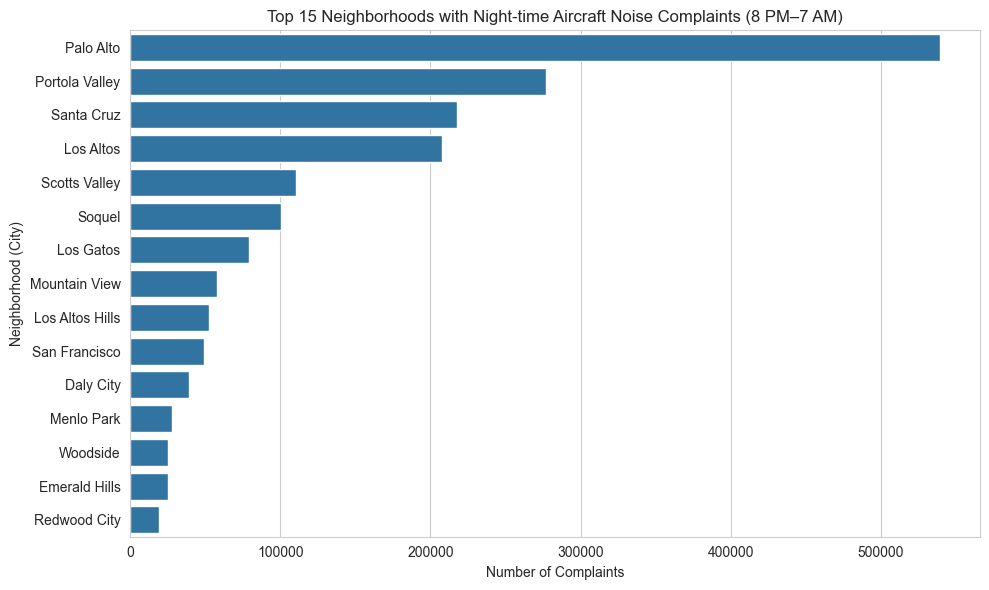

In [109]:
plt.figure(figsize=(10,6))
sns.barplot(
    data=complaints_by_city.head(15),
    x="complaint_count",
    y="reporter_city"
)
plt.title("Top 15 Neighborhoods with Night-time Aircraft Noise Complaints (8 PM–7 AM)")
plt.xlabel("Number of Complaints")
plt.ylabel("Neighborhood (City)")
plt.tight_layout()
plt.show()


the answers show Palo Alto has the most complaints. Redwood city has the lowest.

## 2. Altitude Distribution

We explore whether the altitude of aircraft contributes to complaints.

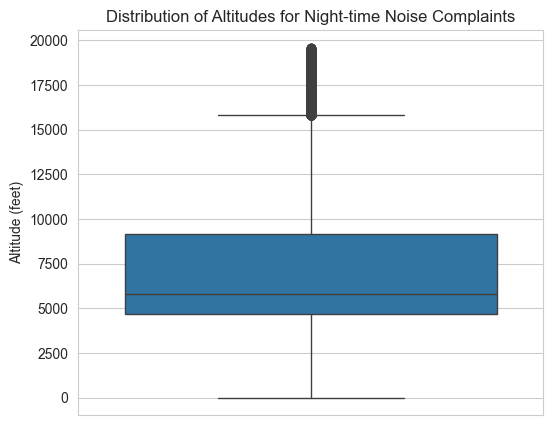

In [110]:
df_alt = df.dropna(subset=['aircraft_pca_altitude'])
df_alt = df_alt[df_alt['aircraft_pca_altitude'] > 0]

plt.figure(figsize=(6,5))
sns.boxplot(data=df_alt, y="aircraft_pca_altitude")
plt.title("Distribution of Altitudes for Night-time Noise Complaints")
plt.ylabel("Altitude (feet)")
plt.show()


## 3. Complaints by Aircraft Type

We count complaints for each aircraft type and visualize the top 10 most and least complaint-generating types.

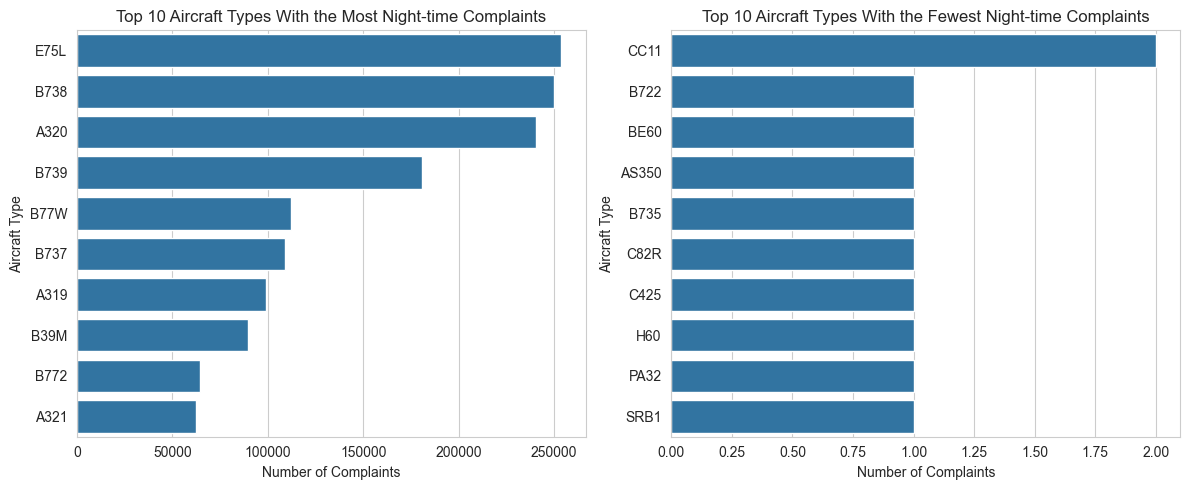

In [ ]:
complaints_by_aircraft = (
    df.groupby('aircraft_type')
      .size()
      .reset_index(name='num_complaints')
      .sort_values(by='num_complaints', ascending=False)
)

complaints_by_aircraft.head()





In [ ]:
# Take top 10 aircraft types by number of complaints
top10_high = complaints_by_aircraft.head(10)
top10_low = complaints_by_aircraft.tail(10)


plt.figure(figsize=(12,5))

# Top 10 highest
plt.subplot(1,2,1)
sns.barplot(data=top10_high, x='num_complaints', y='aircraft_type')
plt.title("Top 10 Aircraft Types With the Most Night-time Complaints")
plt.xlabel("Number of Complaints")
plt.ylabel("Aircraft Type")

# Top 10 lowest
plt.subplot(1,2,2)
sns.barplot(data=top10_low, x='num_complaints', y='aircraft_type')
plt.title("Top 10 Aircraft Types With the Fewest Night-time Complaints")
plt.xlabel("Number of Complaints")
plt.ylabel("Aircraft Type")

plt.tight_layout()
plt.show()

TIME AT NIGHT THAT GENERATE THE MOST AND LEAST COMPLAINT

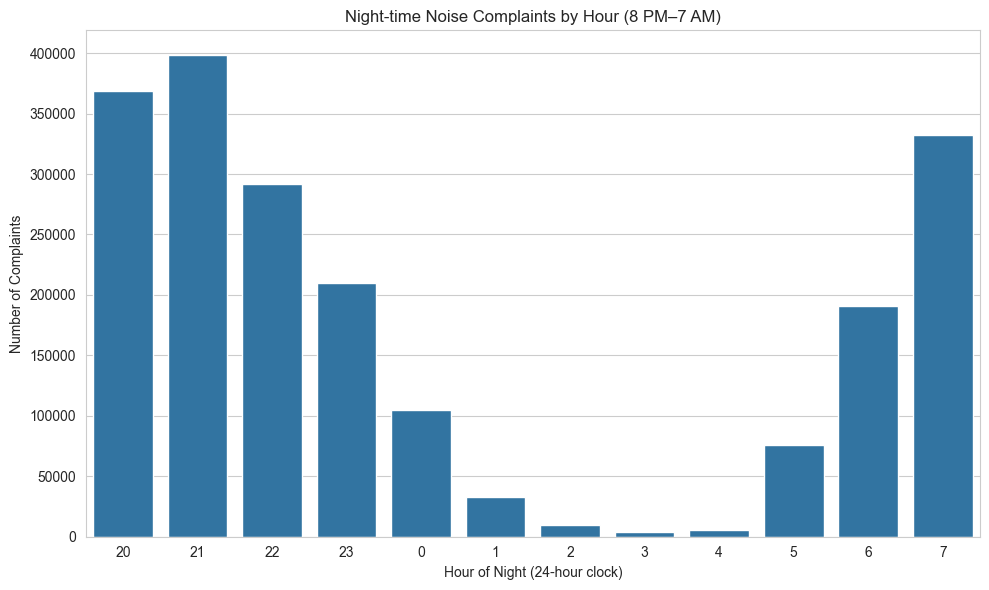

Hour with MOST complaints: 21 with 398842 complaints
Hour with LEAST complaints: 3 with 3782 complaints


In [113]:
# Count complaints for each hour in the night period
complaints_by_hour = (
    df.groupby('hour')
      .size()
      .reset_index(name='num_complaints')
      .sort_values(by='hour')
)
# Count complaints for each hour in the night period
# Define the night hours in order
night_hours = [20, 21, 22, 23, 0, 1, 2, 3, 4, 5, 6, 7]

# Make 'hour' a categorical variable with this order
complaints_by_hour['hour'] = pd.Categorical(
    complaints_by_hour['hour'],
    categories=night_hours,
    ordered=True
)

plt.figure(figsize=(10,6))
sns.barplot(data=complaints_by_hour, x='hour', y='num_complaints')
plt.title("Night-time Noise Complaints by Hour (8 PM–7 AM)")
plt.xlabel("Hour of Night (24-hour clock)")
plt.ylabel("Number of Complaints")
plt.tight_layout()
plt.show()

most = complaints_by_hour.loc[complaints_by_hour['num_complaints'].idxmax()]
least = complaints_by_hour.loc[complaints_by_hour['num_complaints'].idxmin()]

print("Hour with MOST complaints:", int(most['hour']), "with", int(most['num_complaints']), "complaints")
print("Hour with LEAST complaints:", int(least['hour']), "with", int(least['num_complaints']), "complaints")


TIME OF YEAR SEASONAL COMPLAINT

In [42]:
# Function to assign season
def month_to_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:  # 9, 10, 11
        return 'Fall'

# Create a new 'season' column
df['season'] = df['disturbance_date_time'].dt.month.apply(month_to_season)


# Count complaints by season
complaints_by_season = df['season'].value_counts().reindex(['Winter','Spring','Summer','Fall'])



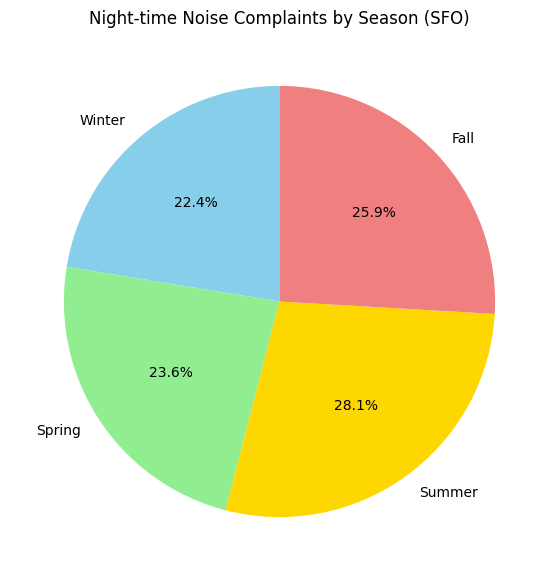

In [43]:
plt.figure(figsize=(7,7))
plt.pie(
    complaints_by_season,
    labels=complaints_by_season.index,
    autopct='%1.1f%%',  # show percentages
    colors=['skyblue','lightgreen','gold','lightcoral'],
    startangle=90
)
plt.title("Night-time Noise Complaints by Season (SFO)")
plt.show()



COUNT COMPLAINTS BY OPERATION TYPE

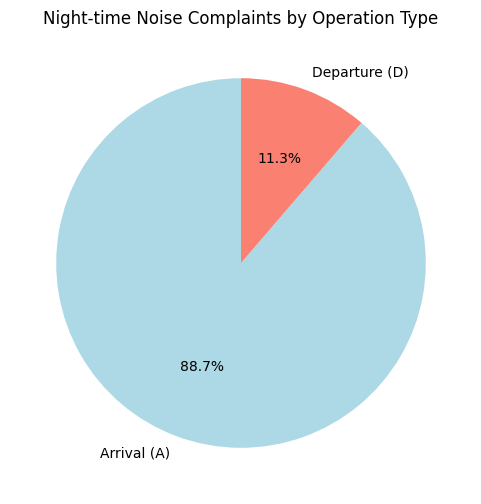

In [44]:
complaints_by_operation = df['operation_type'].value_counts().reindex(['A','D'])



plt.figure(figsize=(6,6))
plt.pie(
    complaints_by_operation,
    labels=['Arrival (A)', 'Departure (D)'],
    autopct='%1.1f%%',
    colors=['lightblue','salmon'],
    startangle=90
)
plt.title("Night-time Noise Complaints by Operation Type")
plt.show()


# Modeling

In [53]:
complaints_by_city.head()

,reporter_city,complaint_count
46,Palo Alto,539153
50,Portola Valley,277261
60,Santa Cruz,217696
33,Los Altos,207734
62,Scotts Valley,110485


In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Fit a linear regression model
model = ols('complaint_count ~ reporter_city', data= complaints_by_city).fit()

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        complaint_count   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 03 Nov 2025   Prob (F-statistic):                nan
Time:                        23:21:40   Log-Likelihood:                 1585.9
No. Observations:                  73   AIC:                            -3026.
Df Residuals:                       0   BIC:                            -2859.
Df Model:                          72                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


In [ ]:
df['state'].value_counts()

In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2025540 entries, 0 to 2025900
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   disturbance_date_time  datetime64[ns]
 1   reporter_city          object        
 2   reporter_postal_code   object        
 3   aircraft_pca_altitude  float64       
 4   airport_id             object        
 5   operation_type         object        
 6   aircraft_type          object        
 7   hour                   int32         
dtypes: datetime64[ns](1), float64(1), int32(1), object(5)
memory usage: 131.4+ MB


In [123]:
df['reporter_city'].value_counts()

reporter_city
Palo Alto         539107
Portola Valley    277241
Santa Cruz        217683
Los Altos         207557
Scotts Valley     110482
                   ...  
Forest Knolls          2
Walnut Creek           1
Piedmont               1
Sf                     1
Colma                  1
Name: count, Length: 73, dtype: int64

In [125]:
df['aircraft_pca_altitude'].value_counts()

aircraft_pca_altitude
10.0       6346
3999.0     5019
3990.0     4810
3993.0     4485
3996.0     4402
           ... 
17533.0       1
170.0         1
19501.0       1
4316.0        1
221.0         1
Name: count, Length: 8618, dtype: int64

In [130]:
df['operation_type'].value_counts()

operation_type
A    1796608
D     228932
Name: count, dtype: int64

In [132]:
df['hour'].value_counts()

hour
21    398842
20    368870
7     332485
22    291762
23    209845
6     190792
0     104874
5      76274
1      32696
2       9490
4       5828
3       3782
Name: count, dtype: int64

In [133]:
df['aircraft_type'].value_counts()

aircraft_type
E75L    253702
B738    249719
A320    240581
B739    180914
B77W    112340
         ...  
PA32         1
C425         1
H60          1
BE60         1
B735         1
Name: count, Length: 204, dtype: int64